# Collect Data and Train SVGP - Retraining, multi-step, var change

## Gaussian Processes

In [1]:

import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np


import os
# libiomp5md.dll, but found libiomp5md.dll already initialized. PROBLEM with OpenMP runtime!
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # UNSAFE workaround, only used for experimentation.

import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader


# ============================================================
# ---- Sparse GP model (SVGP con inducing points) ------------
# ============================================================
class SparseGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel='RBF', ard_dims=None):
        """
        inducing_points: tensor [M, D] ya en el device correcto
        """
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=inducing_points.size(0)
        )

        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )

        super().__init__(variational_strategy)

        # Mean
        self.mean_module = gpytorch.means.ConstantMean()

        # Kernel
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



# ============================================================
# ---- Online Sparse GP Manager ------------------------------
# ============================================================

class OnlineSparseGPManager:
    def __init__(
        self,
        kernel='RBF',
        lr=0.01,
        iters=1000,
        num_inducing=1000,
        batch_size=128,
        device=None,
    ):
        """
        Online GP basado en SVGP (Sparse Variational GP).
        - kernel: 'RBF', 'Matern', 'RQ'
        - lr: learning rate Adam
        - iters: nº máximo de steps de entrenamiento "full" en fit()
        - num_inducing: nº de inducing points M
        - batch_size: tamaño de minibatch para VI
        - device: 'cuda' o 'cpu'
        """
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.num_inducing = num_inducing
        self.batch_size = batch_size
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # Datos en escala original
        self.X = None      # [N, D]
        self.Y = None      # [N]

        # Datos normalizados
        self.Xn = None     # [N, D]
        self.Yn = None     # [N]

        # Normalización (fijamos tras el primer fit)
        self.X_mean = None
        self.X_std = None
        self.Y_mean = None
        self.Y_std = None

        # Modelo SVGP + likelihood
        self.likelihood = None
        self.model = None
        self.mll = None

        self.trained = False


    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        """
        Entrenamiento inicial con todos los datos pasados.
        X: array/tensor [N, D]
        Y: array/tensor [N] o [N, 1]
        """
        # Convertir a tensores en device
        X = torch.as_tensor(X, dtype=torch.float32, device=self.device)
        Y = torch.as_tensor(Y, dtype=torch.float32, device=self.device).flatten()

        self.X = X.clone()
        self.Y = Y.clone()

        # Normalización (la fijamos aquí para todo el online)
        self._compute_normalization(initial=True)

        # Inicializar modelo SVGP + likelihood
        self._init_model()

        # Entrenar varias iteraciones (full training)
        self._train(max_steps=self.iters)

        self.trained = True


    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True, online_steps=50):
        """
        Añadir nuevos datos (online) y entrenar unas pocas steps.
        X_new: [N_new, D]
        Y_new: [N_new]
        online_steps: nº de steps de optimización tras añadir datos
                      (típicamente << self.iters)
        """
        # Convertir a tensores
        X_new = torch.as_tensor(X_new, dtype=torch.float32, device=self.device)
        Y_new = torch.as_tensor(Y_new, dtype=torch.float32, device=self.device).flatten()

        if self.X is None or self.Y is None:
            # Si no había datos, esto equivale a fit()
            self.fit(X_new, Y_new)
            return

        # Apilar a dataset existente (escala original)
        self.X = torch.cat([self.X, X_new], dim=0)
        self.Y = torch.cat([self.Y, Y_new], dim=0)

        # ✅ Importante: mantenemos la normalización ORIGINAL
        # para no romper el modelo. Solo normalizamos los nuevos
        # datos con las mismas X_mean, X_std, etc.
        self._update_normalized_data()

        # Actualizar num_data del ELBO
        self.mll.num_data = self.Yn.size(0)

        if retrain:
            # Entrenamiento "ligero" online (unas pocas steps)
            self._train(max_steps=online_steps)


    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self, initial=False):
        """
        Calcula X_mean, X_std, Y_mean, Y_std a partir de self.X, self.Y.
        Si initial=True se fijan para todo el proceso online.
        """
        if initial or self.X_mean is None:
            self.X_mean = self.X.mean(dim=0)
            self.X_std = self.X.std(dim=0) + 1e-8
            self.Y_mean = self.Y.mean(dim=0)
            self.Y_std = self.Y.std(dim=0) + 1e-8

        # Normalización usando SIEMPRE las mismas medias/varianzas
        self.Xn = (self.X - self.X_mean) / self.X_std
        self.Yn = (self.Y - self.Y_mean) / self.Y_std

    def _update_normalized_data(self):
        """
        Recalcula Xn, Yn con los mismos X_mean, X_std, Y_mean, Y_std
        (no se vuelven a estimar, solo se aplican a los nuevos datos).
        """
        self.Xn = (self.X - self.X_mean) / self.X_std
        self.Yn = (self.Y - self.Y_mean) / self.Y_std

    def dataset(self):
        """
        Devuelve los datos en escala original como numpy (para debug).
        """
        X_np = self.X.detach().cpu().numpy()
        Y_np = self.Y.detach().cpu().numpy()
        return X_np, Y_np

    def _init_model(self):
        """
        Crea el modelo SVGP + likelihood a partir de self.Xn, self.Yn.
        """
        # Elegir inducing points: subset aleatorio de Xn
        N = self.Xn.size(0)
        M = min(self.num_inducing, N)
        perm = torch.randperm(N, device=self.device)
        inducing_points = self.Xn[perm[:M]].contiguous()

        # Likelihood
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood().to(self.device)
        self.likelihood.noise_covar.initialize(noise=1e-3)

        # Modelo SVGP
        self.model = SparseGPModel(
            inducing_points=inducing_points,
            kernel=self.kernel,
            ard_dims=self.Xn.shape[-1],
        ).to(self.device)

        # ELBO variacional
        self.mll = gpytorch.mlls.VariationalELBO(
            likelihood=self.likelihood,
            model=self.model,
            num_data=self.Yn.size(0),
        )

    def _train(self, max_steps=None):
        """
        Entrenamiento variacional (SVGP) con minibatches.
        max_steps: nº máximo de pasos de optimización
        """
        if max_steps is None:
            max_steps = self.iters

        self.model.train()
        self.likelihood.train()

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        dataset = TensorDataset(self.Xn, self.Yn)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        step = 0
        while step < max_steps:
            for Xb, Yb in loader:
                optimizer.zero_grad()
                output = self.model(Xb)
                loss = -self.mll(output, Yb)
                loss.backward()
                optimizer.step()

                step += 1
                if step >= max_steps:
                    break

        self.model.eval()
        self.likelihood.eval()
        self.trained = True


    # ----------------------------- #
    #            PREDICT            #
    # ----------------------------- #
    @torch.no_grad()
    def predict(self, X):
        """
        Predicción de media y varianza en escala ORIGINAL.
        X: [N_test, D]
        Devuelve:
          mean_np: [N_test]
          var_np:  [N_test]
        """
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        X = torch.as_tensor(X, dtype=torch.float32, device=self.device)
        Xn = (X - self.X_mean) / self.X_std

        with gpytorch.settings.fast_pred_var():
            pred_dist = self.likelihood(self.model(Xn))
            mean = pred_dist.mean * self.Y_std + self.Y_mean
            var = pred_dist.variance * (self.Y_std ** 2)

        return mean.detach().cpu().numpy(), var.detach().cpu().numpy()



## Recolección de datos (estado, control, aceleraciones)

Using device: cpu
✅ Simulador inicializado correctamente.
m_drone (estimada): 0.0037699111843077526


Rollout MuJoCo (logs para RLS): 100%|██████████| 2000/2000 [00:00<00:00, 9768.72it/s]


✅ Logs recolectados:
  states      : (2000, 6)  -> [x,z,xdot,zdot,theta,theta_dot]
  actions     : (2000, 2)  -> [uL,uR]
  accels      : (2000, 2)  -> [xddot,zddot] (FD)
  ang_accels  : (2000,)  -> theta_ddot (FD)
  anchor_feat : (2000, 8)  -> [r_x,r_z,r,alpha,r_dotx,r_dotz,theta,theta_dot]


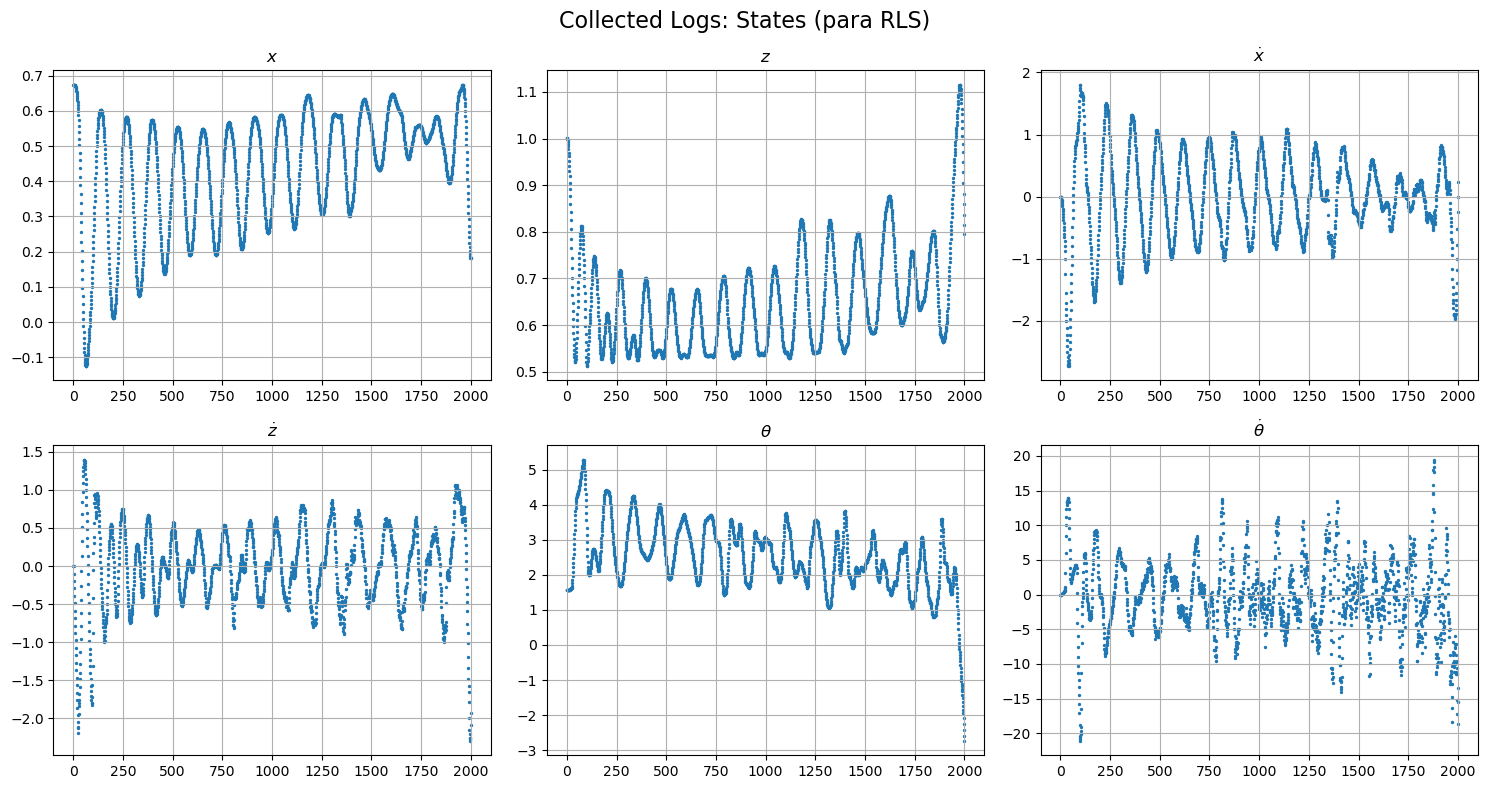

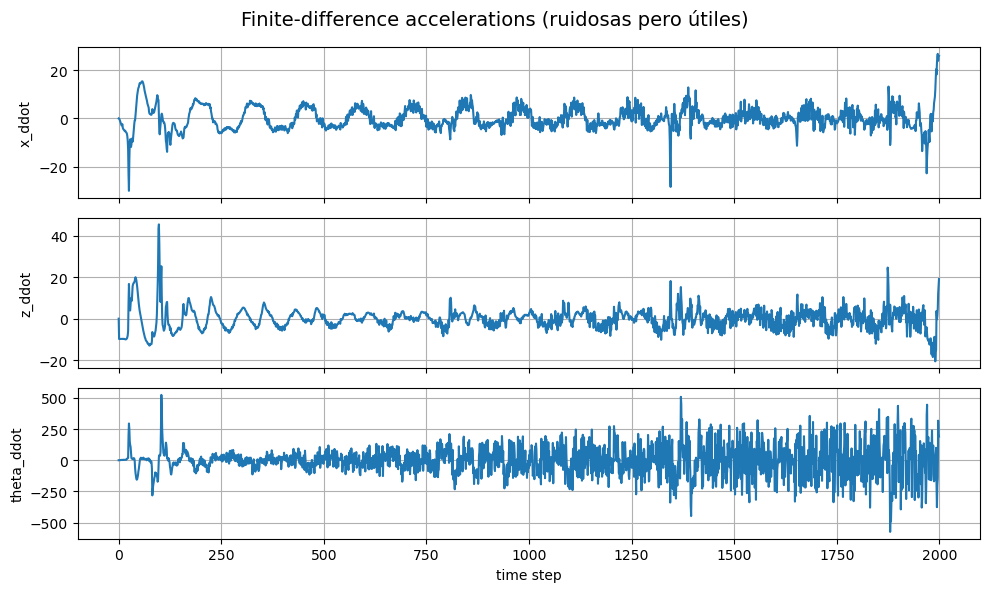

In [14]:
# ===============================================
# 1. Imports y setup MuJoCo + Torch
# ===============================================
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # solo para evitar el warning de OpenMP

import mujoco as mj
import numpy as np
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

from models.cantilever_2d_drone import get_xml  # tu generador XML

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ===============================================
# 2. Crear modelo MuJoCo a partir del XML
# ===============================================
XML = get_xml(num_segmentos=8, longitud_total=0.6)
model = mj.MjModel.from_xml_string(XML)
data = mj.MjData(model)

print("✅ Simulador inicializado correctamente.")

# ============================================================
# 2.1 Parámetros/constantes útiles (para estimar fuerzas/torques)
# ============================================================
# masa del cuerpo principal (ajusta name si tu body no se llama así)
# Puedes inspeccionar model.body(...) según tu XML.
# Si falla, dejamos un fallback.
try:
    drone_body_id = mj.mj_name2id(model, mj.mjtObj.mjOBJ_BODY, "drone")
    m_drone = model.body_mass[drone_body_id]
except Exception:
    m_drone = 1.0
    drone_body_id = None
print(f"m_drone (estimada): {m_drone}")

g = 9.81

# Punto de anclaje en el mundo (ajústalo a tu escena)
# En 2D x-z lo más común es un punto fijo en x,z; y lo ignoramos (y=0)
ANCHOR_W = np.array([0.0, 0.0, 0.8], dtype=np.float32)  # [x,y,z]

# ===============================================
# 3. Utilidades para ángulos y estado del dron
# ===============================================

def unwrap_angle(angle_raw, angle_prev):
    """Devuelve un ángulo continuo, sin saltos bruscos de ±2π."""
    if angle_prev is None:
        return angle_raw

    delta = angle_raw - angle_prev
    if delta > np.pi:
        angle_raw -= 2 * np.pi
    elif delta < -np.pi:
        angle_raw += 2 * np.pi
    return angle_raw


def quat_to_roll_x(quat, prev_roll=None):
    """
    Convierte cuaternión [w,x,y,z] a ángulo de roll alrededor de X,
    y lo hace continuo usando unwrap.
    """
    w, x, y, z = quat
    sinr_cosp = 2.0 * (w * x + y * z)
    cosr_cosp = 1.0 - 2.0 * (x * x + y * y)
    roll_raw = np.arctan2(sinr_cosp, cosr_cosp)
    roll_cont = unwrap_angle(roll_raw, prev_roll)
    return roll_cont


def get_state_from_sensors(data, prev_theta=None):
    """
    Estado 2D:
        s = [x, z, x_dot, z_dot, theta, theta_dot]
    """
    # Posición global
    pos = data.sensor("pos_drone").data  # [x, y, z]
    x, z = float(pos[0]), float(pos[2])

    # Velocidades lineales
    linvel = data.sensor("linvel_drone").data  # [vx, vy, vz]
    x_dot = float(linvel[0])
    z_dot = float(linvel[2])

    # Cuaternión
    quat = data.sensor("quat_drone").data  # [w, x, y, z]
    theta = float(quat_to_roll_x(quat, prev_theta))

    # Velocidad angular
    angvel = data.sensor("rotvel_drone").data  # [wx, wy, wz]
    # OJO: en tu código usabas angvel[1] como theta_dot pero decías "roll alrededor de".
    # Si theta es roll (X), normalmente theta_dot sería wx = angvel[0].
    # Lo dejo como parámetro fácil de cambiar:
    theta_dot = float(angvel[1])  # <- usual para roll alrededor de X

    state = np.array([x, z, x_dot, z_dot, theta, theta_dot], dtype=np.float32)
    return state, theta


def get_anchor_features(state, anchor_w=ANCHOR_W):
    """
    Features geométricas básicas para el anclaje:
      r = p - p_anchor en x-z
      r_dot = v (anclaje fijo)
      alpha = atan2(r_z, r_x)
    Devuelve un dict para comodidad.
    """
    x, z, x_dot, z_dot, theta, theta_dot = state
    r_x = x - anchor_w[0]
    r_z = z - anchor_w[2]
    r = np.sqrt(r_x**2 + r_z**2) + 1e-8
    alpha = np.arctan2(r_z, r_x)  # ángulo hacia el anclaje en el plano x-z

    return {
        "r_x": r_x, "r_z": r_z, "r": r,
        "r_dot_x": x_dot, "r_dot_z": z_dot,
        "alpha": alpha,
        "theta": theta, "theta_dot": theta_dot
    }

# ===============================================
# 4. Rollout (temporal) para recolectar logs útiles a RLS
# ===============================================

def rollout_random_for_rls(model, data, n_steps=5000, anchor_w=ANCHOR_W):
    """
    Ejecuta el simulador con acciones aleatorias y devuelve logs para RLS:
        states:      [N, 6]
        actions:     [N, 2]
        accels:      [N, 2]   -> [x_ddot, z_ddot] estimados (finite difference)
        ang_accels:  [N]      -> theta_ddot estimado (finite difference)
        anchor_feat: [N, ...] -> dict->array (r_x,r_z,r,alpha, etc.) opcional
    NOTA:
      - Para RLS estilo paper, lo que eventualmente quieres es estimar fuerza/torque externo.
      - Aquí guardamos aceleraciones para poder estimarlos (con cuidado de ruido).
    """
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    states = []
    actions = []
    xdd = []
    zdd = []
    thdd = []
    anchor_feats = []

    prev_theta = None

    # Para derivadas (finite difference)
    dt = model.opt.timestep
    prev_vx = None
    prev_vz = None
    prev_w  = None  # theta_dot

    for step in tqdm(range(n_steps), desc="Rollout MuJoCo (logs para RLS)"):
        s_t, prev_theta = get_state_from_sensors(data, prev_theta)

        # Acción aleatoria suave
        scale = (step / n_steps)
        a_t = np.random.uniform(0.0, 2.0 * scale + 1e-3, size=2).astype(np.float32)
        data.ctrl[:] = a_t

        # avanzar
        mj.mj_step(model, data)

        # estado siguiente (para estimar derivadas)
        s_next, prev_theta = get_state_from_sensors(data, prev_theta)

        # extraer velocidades actuales (post-step)
        vx, vz = float(s_next[2]), float(s_next[3])
        w      = float(s_next[5])

        if prev_vx is None:
            ax = 0.0
            az = 0.0
            aw = 0.0
        else:
            ax = (vx - prev_vx) / dt
            az = (vz - prev_vz) / dt
            aw = (w  - prev_w)  / dt

        prev_vx, prev_vz, prev_w = vx, vz, w

        states.append(s_t)
        actions.append(a_t)
        xdd.append(ax)
        zdd.append(az)
        thdd.append(aw)

        feat = get_anchor_features(s_t, anchor_w=anchor_w)
        anchor_feats.append([feat["r_x"], feat["r_z"], feat["r"], feat["alpha"],
                             feat["r_dot_x"], feat["r_dot_z"], feat["theta"], feat["theta_dot"]])

    states = np.stack(states, axis=0)      # [N, 6]
    actions = np.stack(actions, axis=0)    # [N, 2]
    accels = np.stack([xdd, zdd], axis=1).astype(np.float32)   # [N, 2]
    ang_accels = np.array(thdd, dtype=np.float32)              # [N]
    anchor_feats = np.array(anchor_feats, dtype=np.float32)    # [N, 8]

    return states, actions, accels, ang_accels, anchor_feats


# ===============================================
# 5. Recolectar logs
# ===============================================
N_STEPS = 2000
states, actions, accels, ang_accels, anchor_feats = rollout_random_for_rls(
    model, data, n_steps=N_STEPS, anchor_w=ANCHOR_W
)

print("✅ Logs recolectados:")
print("  states      :", states.shape, " -> [x,z,xdot,zdot,theta,theta_dot]")
print("  actions     :", actions.shape, " -> [uL,uR]")
print("  accels      :", accels.shape, " -> [xddot,zddot] (FD)")
print("  ang_accels  :", ang_accels.shape, " -> theta_ddot (FD)")
print("  anchor_feat :", anchor_feats.shape, " -> [r_x,r_z,r,alpha,r_dotx,r_dotz,theta,theta_dot]")

# ===============================================
# 6. Visualización rápida (igual que antes)
# ===============================================
rng = N_STEPS
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
labels = [r'$x$', r'$z$', r'$\dot{x}$', r'$\dot{z}$', r'$\theta$', r'$\dot{\theta}$']

for i, ax in enumerate(axes.flat):
    ax.scatter(np.linspace(0, rng, rng), states[:rng, i], s=2)
    ax.set_title(labels[i])
    ax.grid(True)

plt.suptitle("Collected Logs: States (para RLS)", fontsize=16)
plt.tight_layout()
plt.show()

# (Opcional) ver aceleraciones estimadas
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
axes[0].plot(accels[:, 0]); axes[0].set_ylabel("x_ddot")
axes[1].plot(accels[:, 1]); axes[1].set_ylabel("z_ddot")
axes[2].plot(ang_accels);   axes[2].set_ylabel("theta_ddot")
for ax in axes: ax.grid(True)
axes[2].set_xlabel("time step")
plt.suptitle("Finite-difference accelerations (ruidosas pero útiles)", fontsize=14)
plt.tight_layout()
plt.show()


## RLS + observer de fuerza/torque (sin controlador aún)

m_drone: 0.16 J_y: 0.00039741666666666674


Rollout + RLS online:   0%|          | 0/3000 [00:00<?, ?it/s]C:\Users\Edward Caleb\AppData\Local\Temp\ipykernel_17640\978028251.py:132: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom = float(self.lam + (phi.T @ Pphi))  # scalar
Rollout + RLS online: 100%|██████████| 3000/3000 [00:00<00:00, 3859.34it/s]


✅ RLS terminado. Shapes:
states_rls: (3000, 6)
f_ext_log: (3000, 2) f_hat_log: (3000, 2)
tau_ext_log: (3000,) tau_hat_log: (3000,)


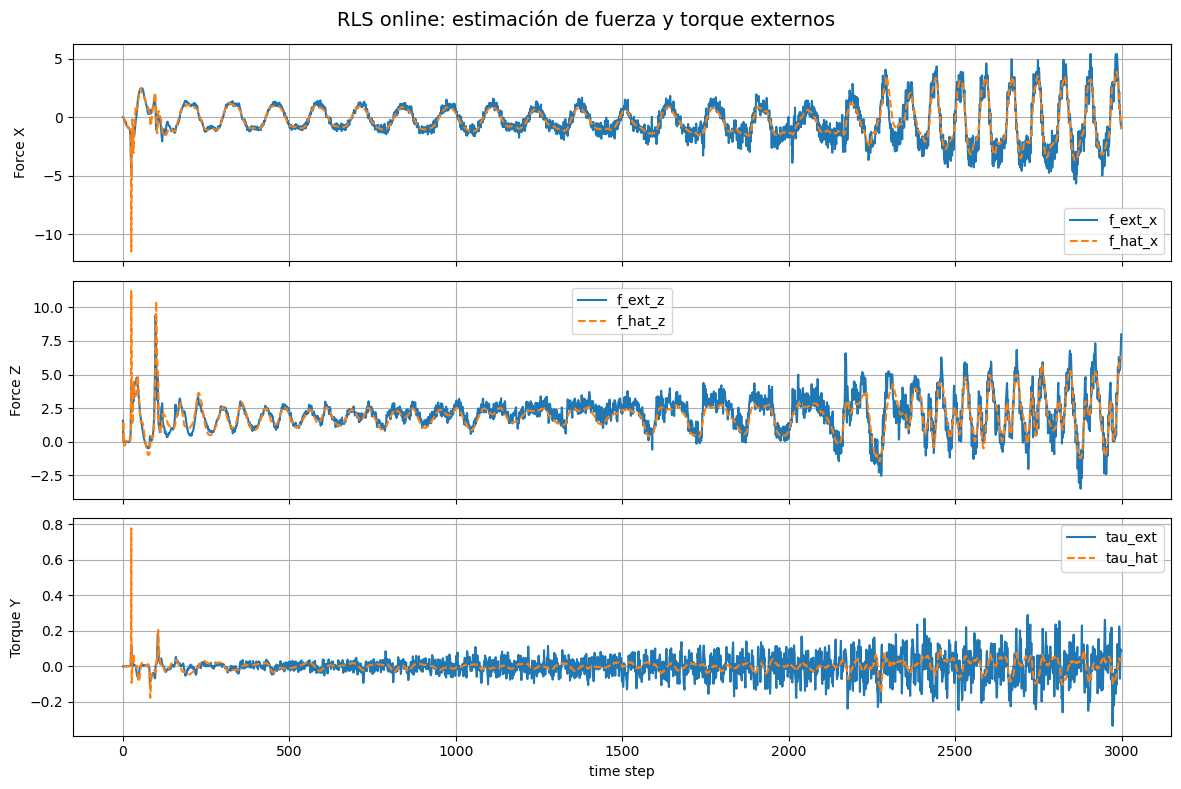

In [ ]:
# ===============================================
# 7. Utilidades: thrust/torque y "targets" (f_o, tau_o)
# ===============================================

def get_drone_mass_and_Jy(model, body_name="drone"):
    """Lee masa y Jy del body del dron desde MuJoCo."""
    body_id = mj.mj_name2id(model, mj.mjtObj.mjOBJ_BODY, body_name)
    m = float(model.body_mass[body_id])
    # body_inertia: [Ixx, Iyy, Izz] en el frame del body (aprox)
    Ixx, Iyy, Izz = model.body_inertia[body_id]
    Jy = float(Iyy)
    return m, Jy, body_id


# Ajusta estos nombres/valores según tu XML
DRONE_BODY_NAME = "drone_2d"

m_drone, J_y, drone_body_id = get_drone_mass_and_Jy(model, DRONE_BODY_NAME)
print("m_drone:", m_drone, "J_y:", J_y)

# Brazo efectivo para torque (distancia del centro al motor).
# Si tu XML lo define, lo ideal es leerlo; por ahora lo dejamos como parámetro.
ARM = 0.08  # <-- AJUSTAR al dron (metros)


def control_force_world(theta, u_left, u_right):
    """
    Fuerza de control en mundo (2D x-z) asumiendo:
    - los motores empujan en el eje +Z del body
    - el body rota en pitch alrededor de Y
    Entonces la dirección del empuje en mundo es:
      [sin(theta), cos(theta)] en (x,z) si z es vertical.
    """
    T = float(u_left + u_right)  # thrust total
    fx = T * np.sin(theta)
    fz = T * np.cos(theta)
    return np.array([fx, fz], dtype=np.float32)


def control_torque_y(u_left, u_right, arm=ARM):
    """
    Torque alrededor de Y por diferencia de empujes.
    Convención típica planar:
      tau_y = arm * (u_right - u_left)
    Ajusta signo si ves que el giro se invierte.
    """
    return float(arm * (u_right - u_left))


def finite_diff(prev, curr, dt):
    return (curr - prev) / dt


# ===============================================
# 8. Features (phi, psi) para RLS
# ===============================================

def make_features_force(state, anchor_w=ANCHOR_W, order=2):
    """
    Feature vector pequeño (rápido) para f_o = W^T phi.
    Usa geometría del anclaje + estado.
    """
    feat = get_anchor_features(state, anchor_w=anchor_w)
    rx, rz = feat["r_x"], feat["r_z"]
    rdx, rdz = feat["r_dot_x"], feat["r_dot_z"]
    theta, theta_dot = feat["theta"], feat["theta_dot"]

    # base
    phi = [rx, rz, rdx, rdz, np.sin(theta), np.cos(theta), theta_dot, 1.0]

    if order >= 2:
        phi += [rx*rx, rz*rz, rx*rz, rdx*rdx, rdz*rdz, rdx*rdz]

    return np.array(phi, dtype=np.float32)  # [p]


def make_features_torque(state, anchor_w=ANCHOR_W, order=2):
    """
    Feature vector para tau_o = V^T psi (torque externo).
    Similar al de fuerza, pero aquí suele ayudar meter más orientación.
    """
    feat = get_anchor_features(state, anchor_w=anchor_w)
    rx, rz = feat["r_x"], feat["r_z"]
    r = feat["r"]
    alpha = feat["alpha"]
    theta, theta_dot = feat["theta"], feat["theta_dot"]
    rdx, rdz = feat["r_dot_x"], feat["r_dot_z"]

    psi = [rx, rz, r, np.sin(alpha), np.cos(alpha),
           np.sin(theta), np.cos(theta), theta_dot,
           rdx, rdz,
           1.0]

    if order >= 2:
        psi += [rx*rx, rz*rz, rx*rz, theta_dot*theta_dot, rdx*rdx, rdz*rdz]

    return np.array(psi, dtype=np.float32)


# ===============================================
# 9. RLS (discreto) multioutput (fuerza 2D) y escalar (torque)
# ===============================================

class RLSMultiOutput:
    """
    RLS discreto para y in R^m: y = W^T phi
    - phi: [p]
    - y:   [m]
    - W:   [p, m]
    """
    def __init__(self, p, m, lam=0.999, delta=10.0):
        self.p = p
        self.m = m
        self.lam = lam
        self.W = np.zeros((p, m), dtype=np.float32)
        self.P = (delta * np.eye(p)).astype(np.float32)

    def predict(self, phi):
        return (self.W.T @ phi).astype(np.float32)  # [m]

    def update(self, phi, y):
        """
        Discrete RLS update:
          K = P phi / (lam + phi^T P phi)
          W = W + K (y - W^T phi)^T
          P = (P - K phi^T P) / lam
        """
        phi = phi.reshape(-1, 1)           # [p,1]
        y = y.reshape(-1, 1)               # [m,1]

        Pphi = self.P @ phi                # [p,1]
        denom = float(self.lam + (phi.T @ Pphi))  # scalar
        K = Pphi / (denom + 1e-8)          # [p,1]

        y_hat = (self.W.T @ phi)           # [m,1]
        err = y - y_hat                    # [m,1]

        self.W = self.W + (K @ err.T).astype(np.float32)  # [p,m]
        self.P = ((self.P - (K @ phi.T @ self.P)) / self.lam).astype(np.float32)

        return err.flatten().astype(np.float32)


class RLSSingleOutput(RLSMultiOutput):
    def __init__(self, p, lam=0.999, delta=10.0):
        super().__init__(p=p, m=1, lam=lam, delta=delta)

    def predict(self, phi):
        return float(super().predict(phi)[0])

    def update(self, phi, y_scalar):
        y = np.array([y_scalar], dtype=np.float32)
        err = super().update(phi, y)
        return float(err[0])


# ===============================================
# 10. Rollout + aprendizaje online RLS (random actions)
# ===============================================

def rollout_random_with_rls(model, data, n_steps=3000, anchor_w=ANCHOR_W,
                            lam=0.999, delta=50.0, feat_order=2):
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    dt = model.opt.timestep

    # Estado inicial
    prev_theta = None
    s_t, prev_theta = get_state_from_sensors(data, prev_theta)

    # Buffers para derivadas
    prev_vx, prev_vz = s_t[2], s_t[3]
    prev_wy = s_t[5]

    # Inicializar RLS con tamaños de features
    phi0 = make_features_force(s_t, anchor_w=anchor_w, order=feat_order)
    psi0 = make_features_torque(s_t, anchor_w=anchor_w, order=feat_order)

    rls_f = RLSMultiOutput(p=len(phi0), m=2, lam=lam, delta=delta)  # fx,fz
    rls_tau = RLSSingleOutput(p=len(psi0), lam=lam, delta=delta)

    # Logs
    log_states = []
    log_actions = []
    log_f_ext = []
    log_f_hat = []
    log_tau_ext = []
    log_tau_hat = []

    for step in tqdm(range(n_steps), desc="Rollout + RLS online"):
        # --- estado actual ---
        s_t, prev_theta = get_state_from_sensors(data, prev_theta)
        x, z, vx, vz, theta, wy = s_t  # wy = theta_dot (angvel[1])

        # --- acción aleatoria ---
        scale = (step / n_steps)
        u = np.random.uniform(0.0, 2.0 * scale + 1e-3, size=2).astype(np.float32)
        uL, uR = float(u[0]), float(u[1])
        data.ctrl[:] = u

        # --- step simulación ---
        mj.mj_step(model, data)

        # --- leer estado siguiente para derivadas (aceleraciones) ---
        s_next, prev_theta = get_state_from_sensors(data, prev_theta)
        vx2, vz2, wy2 = float(s_next[2]), float(s_next[3]), float(s_next[5])

        ax = finite_diff(prev_vx, vx2, dt)
        az = finite_diff(prev_vz, vz2, dt)
        alpha_w = finite_diff(prev_wy, wy2, dt)  # theta_ddot aprox

        prev_vx, prev_vz, prev_wy = vx2, vz2, wy2

        # --- fuerza/torque de control (modelo simple) ---
        f_ctrl = control_force_world(theta, uL, uR)          # [fx,fz]
        tau_ctrl = control_torque_y(uL, uR, arm=ARM)         # scalar

        # --- targets "observados" de fuerza/torque externo ---
        # f_ext = m*a + m*g*zhat - f_ctrl
        f_ext = np.array([m_drone*ax, m_drone*az + m_drone*g], dtype=np.float32) - f_ctrl

        # tau_ext = J * wy_dot - tau_ctrl
        tau_ext = float(J_y * alpha_w - tau_ctrl)

        # --- features ---
        phi = make_features_force(s_t, anchor_w=anchor_w, order=feat_order)
        psi = make_features_torque(s_t, anchor_w=anchor_w, order=feat_order)

        # --- predicción + update RLS ---
        f_hat = rls_f.predict(phi)
        tau_hat = rls_tau.predict(psi)

        rls_f.update(phi, f_ext)
        rls_tau.update(psi, tau_ext)

        # --- logs ---
        log_states.append(s_t.copy())
        log_actions.append(u.copy())
        log_f_ext.append(f_ext.copy())
        log_f_hat.append(f_hat.copy())
        log_tau_ext.append(tau_ext)
        log_tau_hat.append(tau_hat)

    return (np.array(log_states), np.array(log_actions),
            np.array(log_f_ext), np.array(log_f_hat),
            np.array(log_tau_ext), np.array(log_tau_hat),
            rls_f, rls_tau)


# ===============================================
# 11. Ejecutar y visualizar aprendizaje RLS
# ===============================================

N_RLS = 3000
(states_rls, actions_rls,
 f_ext_log, f_hat_log,
 tau_ext_log, tau_hat_log,
 rls_f, rls_tau) = rollout_random_with_rls(model, data, n_steps=N_RLS)

print("✅ RLS terminado. Shapes:")
print("states_rls:", states_rls.shape)
print("f_ext_log:", f_ext_log.shape, "f_hat_log:", f_hat_log.shape)
print("tau_ext_log:", tau_ext_log.shape, "tau_hat_log:", tau_hat_log.shape)

# --- plots ---
t = np.arange(N_RLS)

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
axes[0].plot(t, f_ext_log[:,0], label="f_ext_x")
axes[0].plot(t, f_hat_log[:,0], "--", label="f_hat_x")
axes[0].set_ylabel("Force X")
axes[0].grid(True); axes[0].legend()

axes[1].plot(t, f_ext_log[:,1], label="f_ext_z")
axes[1].plot(t, f_hat_log[:,1], "--", label="f_hat_z")
axes[1].set_ylabel("Force Z")
axes[1].grid(True); axes[1].legend()

axes[2].plot(t, tau_ext_log, label="tau_ext")
axes[2].plot(t, tau_hat_log, "--", label="tau_hat")
axes[2].set_ylabel("Torque Y")
axes[2].set_xlabel("time step")
axes[2].grid(True); axes[2].legend()

plt.suptitle("RLS online: estimación de fuerza y torque externos", fontsize=14)
plt.tight_layout()
plt.show()


## Control (planar geométrico) + RLS (online)

Closed-loop geom+RLS:   0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\Edward Caleb\AppData\Local\Temp\ipykernel_17640\978028251.py:132: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom = float(self.lam + (phi.T @ Pphi))  # scalar
Closed-loop geom+RLS: 100%|██████████| 2000/2000 [00:00<00:00, 2567.13it/s]


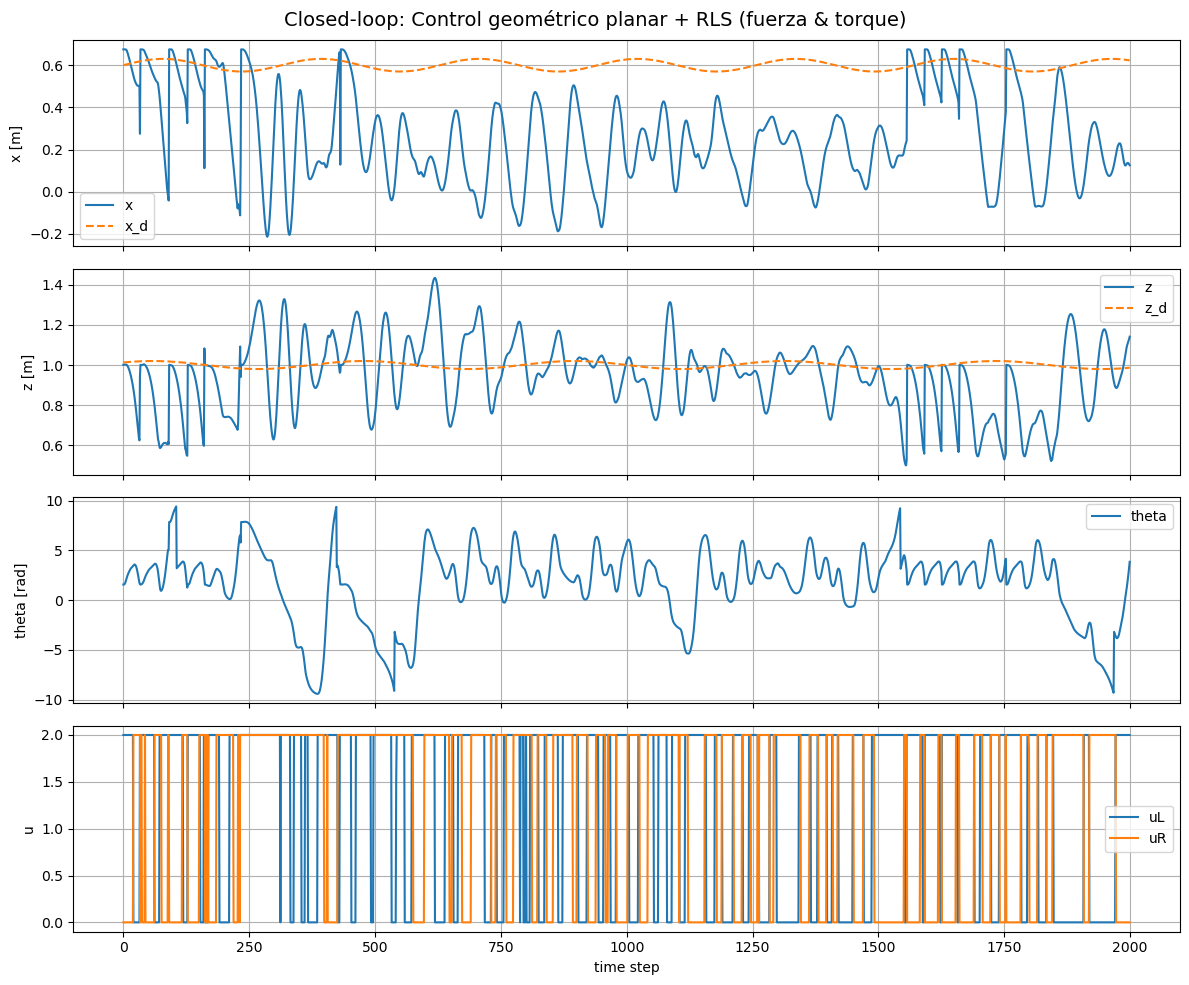

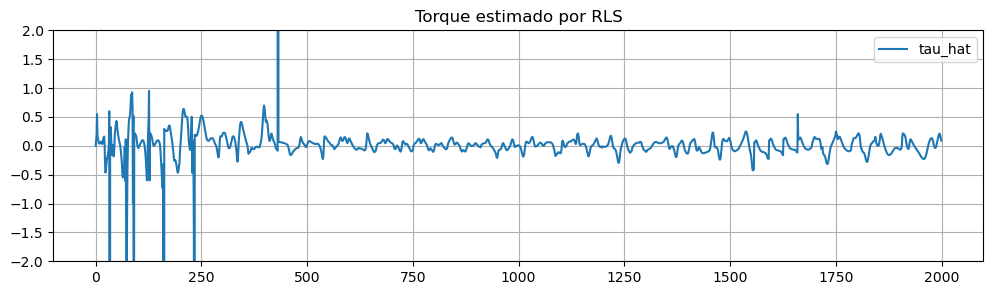

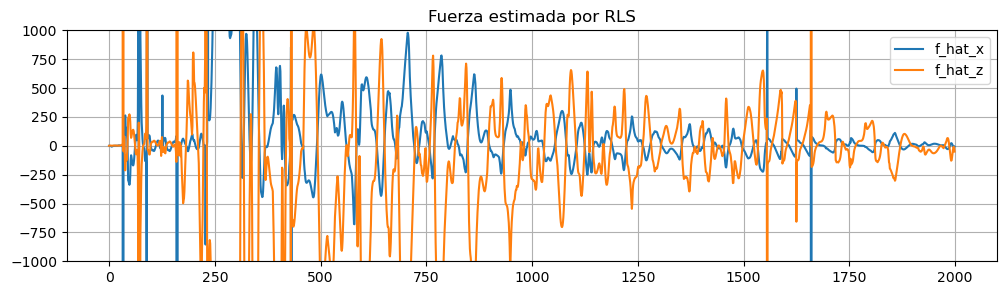

In [45]:
# ===============================================
# 12. Parámetros del control + helpers
# ===============================================

# límites de control de actuadores (desde XML ctrlrange="0 2")
U_MIN, U_MAX = 0.0, 2.0

# "brazo" efectivo para torque diferencial (del gear ±0.05)
# En tu XML, motor_left torque = -0.05, motor_right torque = +0.05
ARM_EFF = 0.05  # usa este por defecto (coincide con XML)

# ganancias (ajusta)
Kp_pos = np.diag([10.0, 20.0])     # para x,z
Kd_pos = np.diag([6.0, 8.0])

Kp_att = 8.0     # sobre theta
Kd_att = 2.0     # sobre theta_dot

# objetivo simple: hover en un punto
p_goal = np.array([0.60, 1.00], dtype=np.float32)   # [x,z]
v_goal = np.array([0.0, 0.0], dtype=np.float32)
a_goal = np.array([0.0, 0.0], dtype=np.float32)

def wrap_pi(a):
    """wrap angle to [-pi, pi]"""
    return (a + np.pi) % (2*np.pi) - np.pi

def clip_u(u):
    return np.clip(u, U_MIN, U_MAX).astype(np.float32)

def thrust_and_theta_from_F(Fx, Fz, eps=1e-6):
    """
    Convierte una fuerza deseada en mundo (x,z) a:
      - theta_d: orientación tal que el empuje apunte en la dirección de F
      - T_d: magnitud de empuje
    Asume empuje en +z_body y rotación alrededor de Y.
    """
    T = float(np.sqrt(Fx*Fx + Fz*Fz) + eps)
    theta_d = float(np.arctan2(Fx, Fz))  # porque:
    # Fx = T sin(theta), Fz = T cos(theta)
    return T, theta_d

def mixer_to_motors(T, tau, arm=ARM_EFF):
    """
    Mezcla thrust total y torque (planar) a motores:
      uL + uR = T
      arm*(uR - uL) = tau
    => uR = 0.5*(T + tau/arm), uL = 0.5*(T - tau/arm)
    """
    uR = 0.5 * (T + tau / (arm + 1e-8))
    uL = 0.5 * (T - tau / (arm + 1e-8))
    return float(uL), float(uR)


# ===============================================
# 13. RLS (re-usa tus clases del Paso 2)
#     Asumimos ya definidas:
#       - make_features_force
#       - make_features_torque
#       - RLSMultiOutput, RLSSingleOutput
#       - control_force_world, control_torque_y
# ===============================================


# ===============================================
# 14. Loop de control en lazo cerrado: geométrico planar + RLS
# ===============================================

def run_closed_loop_geom_rls(model, data, T_sim=2000, anchor_w=ANCHOR_W,
                             lam=0.999, delta=50.0, feat_order=2,
                             add_pe_dither=True):
    """
    Corre el controlador:
      - outer loop posición -> F_des
      - inner loop actitud  -> tau_des
      - compensación RLS: -f_hat, -tau_hat
      - mixer -> uL,uR
      - update RLS online usando observación de fuerza/torque externo
    """

    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    dt = model.opt.timestep

    # init state
    prev_theta = None
    s, prev_theta = get_state_from_sensors(data, prev_theta)

    # init RLS sizes
    phi0 = make_features_force(s, anchor_w=anchor_w, order=feat_order)
    psi0 = make_features_torque(s, anchor_w=anchor_w, order=feat_order)
    rls_f = RLSMultiOutput(p=len(phi0), m=2, lam=lam, delta=delta)
    rls_tau = RLSSingleOutput(p=len(psi0), lam=lam, delta=delta)

    # para derivadas (FD) -> aceleraciones
    prev_vx, prev_vz = float(s[2]), float(s[3])
    prev_wy = float(s[5])

    # logs
    log_s = []
    log_u = []
    log_fhat = []
    log_tauhat = []
    log_Fdes = []
    log_taudes = []
    log_pdes = []
    log_err_p = []

    for t in tqdm(range(T_sim), desc="Closed-loop geom+RLS"):
        # -------------------------
        # leer estado
        # -------------------------
        s, prev_theta = get_state_from_sensors(data, prev_theta)
        x, z, vx, vz, theta, wy = map(float, s)

        p = np.array([x, z], dtype=np.float32)
        v = np.array([vx, vz], dtype=np.float32)

        # -------------------------
        # trayectoria deseada (hover) + opcional excitación persistente
        # -------------------------
        p_d = p_goal.copy()
        v_d = v_goal.copy()
        a_d = a_goal.copy()

        if add_pe_dither:
            # pequeño dither (PE) para que RLS aprenda más rápido sin volverse loco
            # (puedes apagarlo después del aprendizaje)
            p_d[0] += 0.03 * np.sin(0.02 * t)
            p_d[1] += 0.02 * np.sin(0.015 * t + 0.7)
            v_d[0] += 0.03 * 0.02 * np.cos(0.02 * t)
            v_d[1] += 0.02 * 0.015 * np.cos(0.015 * t + 0.7)

        # -------------------------
        # (A) OUTER LOOP: fuerza deseada (mundo) para tracking de posición
        # -------------------------
        e_p = p_d - p
        e_v = v_d - v

        # aceleración deseada
        a_cmd = a_d + (Kp_pos @ e_p) + (Kd_pos @ e_v)   # [ax, az]

        # fuerza deseada TOTAL en mundo: m*a_cmd + gravedad
        F_des = np.array([m_drone * a_cmd[0],
                          m_drone * a_cmd[1] + m_drone * g], dtype=np.float32)

        # -------------------------
        # (B) RLS: predecir fuerza/torque externos (objeto)
        # -------------------------
        phi = make_features_force(s, anchor_w=anchor_w, order=feat_order)
        psi = make_features_torque(s, anchor_w=anchor_w, order=feat_order)

        f_hat = rls_f.predict(phi)          # [fx,fz]
        tau_hat = rls_tau.predict(psi)      # scalar

        # compensación: queremos que el control cancele ese disturbio
        F_eff = F_des - f_hat

        # -------------------------
        # (C) Convertir F_eff -> (T_d, theta_d)
        # -------------------------
        T_d, theta_d = thrust_and_theta_from_F(F_eff[0], F_eff[1])

        # -------------------------
        # (D) INNER LOOP: control geométrico planar en theta
        # -------------------------
        e_theta = wrap_pi(theta_d - theta)
        e_w = (0.0 - wy)  # deseamos wy_d = 0 en hover (puedes poner feedforward)

        tau_des = Kp_att * e_theta + Kd_att * e_w

        # compensación torque externo
        tau_eff = float(tau_des - tau_hat)

        # -------------------------
        # (E) Mixer -> uL,uR (y saturación)
        # -------------------------
        uL, uR = mixer_to_motors(T_d, tau_eff, arm=ARM_EFF)
        u = clip_u(np.array([uL, uR], dtype=np.float32))

        data.ctrl[:] = u
        mj.mj_step(model, data)

        # -------------------------
        # (F) Update RLS usando observación de f_ext, tau_ext
        # -------------------------
        # leer nuevo estado (post-step) para derivadas
        s_next, prev_theta = get_state_from_sensors(data, prev_theta)
        vx2, vz2, wy2 = float(s_next[2]), float(s_next[3]), float(s_next[5])

        ax = (vx2 - prev_vx) / dt
        az = (vz2 - prev_vz) / dt
        wy_dot = (wy2 - prev_wy) / dt

        prev_vx, prev_vz, prev_wy = vx2, vz2, wy2

        # fuerza/torque "de control" (lo que mandaste)
        f_ctrl = control_force_world(theta, float(u[0]), float(u[1]))
        tau_ctrl = control_torque_y(float(u[0]), float(u[1]), arm=ARM_EFF)

        # disturbio observado (aprox)
        f_ext = np.array([m_drone * ax,
                          m_drone * az + m_drone * g], dtype=np.float32) - f_ctrl
        tau_ext = float(J_y * wy_dot - tau_ctrl)

        # actualizar RLS con el estado s (pre-step) y targets observados
        rls_f.update(phi, f_ext)
        rls_tau.update(psi, tau_ext)

        # -------------------------
        # logs
        # -------------------------
        log_s.append(s.copy())
        log_u.append(u.copy())
        log_fhat.append(f_hat.copy())
        log_tauhat.append(tau_hat)
        log_Fdes.append(F_des.copy())
        log_taudes.append(tau_des)
        log_pdes.append(p_d.copy())
        log_err_p.append(e_p.copy())

    return (np.array(log_s), np.array(log_u),
            np.array(log_fhat), np.array(log_tauhat),
            np.array(log_Fdes), np.array(log_taudes),
            np.array(log_pdes), np.array(log_err_p),
            rls_f, rls_tau)


# ===============================================
# 15. Ejecutar y graficar resultados
# ===============================================

T_SIM = 2000
(log_s, log_u,
 log_fhat, log_tauhat,
 log_Fdes, log_taudes,
 log_pdes, log_err_p,
 rls_f, rls_tau) = run_closed_loop_geom_rls(model, data, T_sim=T_SIM)

log_s = np.array(log_s)
t = np.arange(T_SIM)

# estados
x = log_s[:,0]; z = log_s[:,1]
theta = log_s[:,4]; theta_dot = log_s[:,5]

# refs
pdes = np.array(log_pdes)
x_d = pdes[:,0]; z_d = pdes[:,1]

# controles
uL = log_u[:,0]; uR = log_u[:,1]

# plots
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
axes[0].plot(t, x, label="x"); axes[0].plot(t, x_d, "--", label="x_d")
axes[0].set_ylabel("x [m]"); axes[0].grid(True); axes[0].legend()

axes[1].plot(t, z, label="z"); axes[1].plot(t, z_d, "--", label="z_d")
axes[1].set_ylabel("z [m]"); axes[1].grid(True); axes[1].legend()

axes[2].plot(t, theta, label="theta"); axes[2].set_ylabel("theta [rad]")
axes[2].grid(True); axes[2].legend()

axes[3].plot(t, uL, label="uL"); axes[3].plot(t, uR, label="uR")
axes[3].set_ylabel("u"); axes[3].set_xlabel("time step")
axes[3].grid(True); axes[3].legend()

plt.suptitle("Closed-loop: Control geométrico planar + RLS (fuerza & torque)", fontsize=14)
plt.tight_layout()
plt.show()

# ver aprendizaje de torque estimado
plt.figure(figsize=(12,3))
plt.plot(log_tauhat, label="tau_hat")
plt.grid(True); plt.legend(); plt.title("Torque estimado por RLS")
plt.ylim(-2.0, 2.0)
plt.show()

# ver fuerza estimada
plt.figure(figsize=(12,3))
plt.plot(log_fhat[:,0], label="f_hat_x")
plt.plot(log_fhat[:,1], label="f_hat_z")
plt.grid(True); plt.legend(); plt.title("Fuerza estimada por RLS")
plt.ylim(-1000.0, 1000.0)
plt.show()


## Visualization

⚙️ Calculando predicciones GP (una sola vez)...
✅ Predicciones GP precomputadas.

🚀 Generando figuras de comparación compactas (2x3 por tipo)...


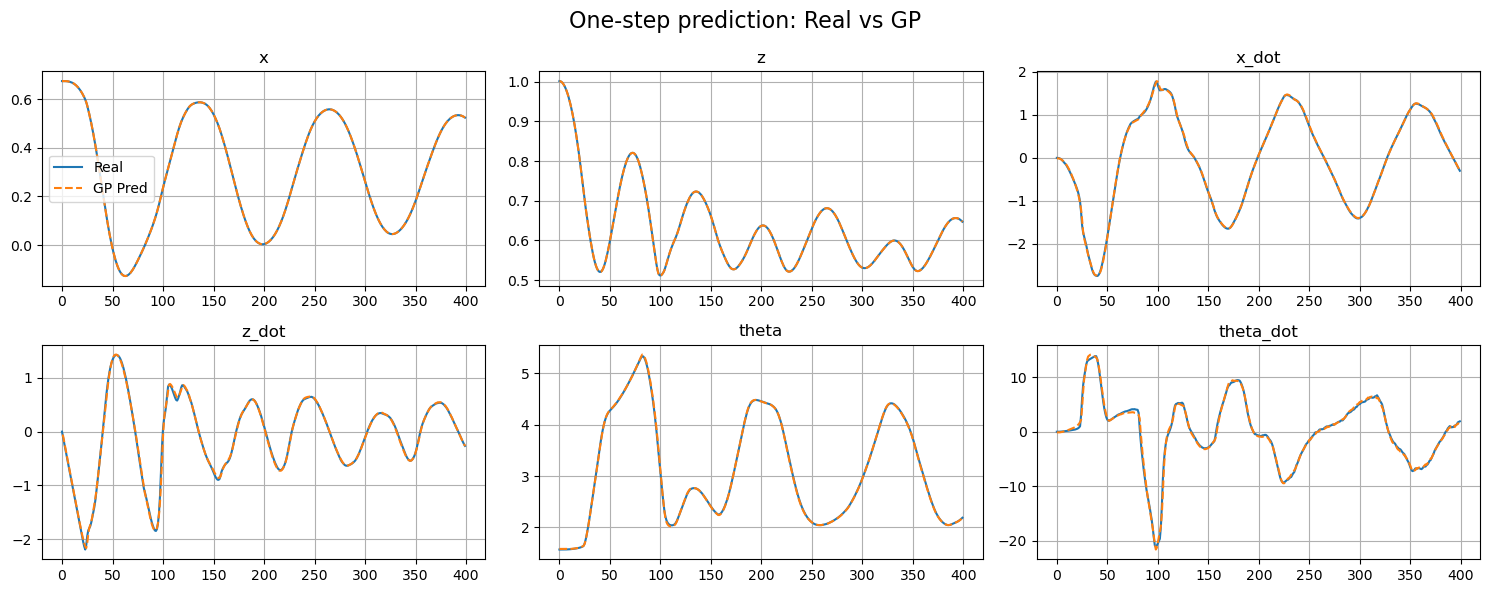

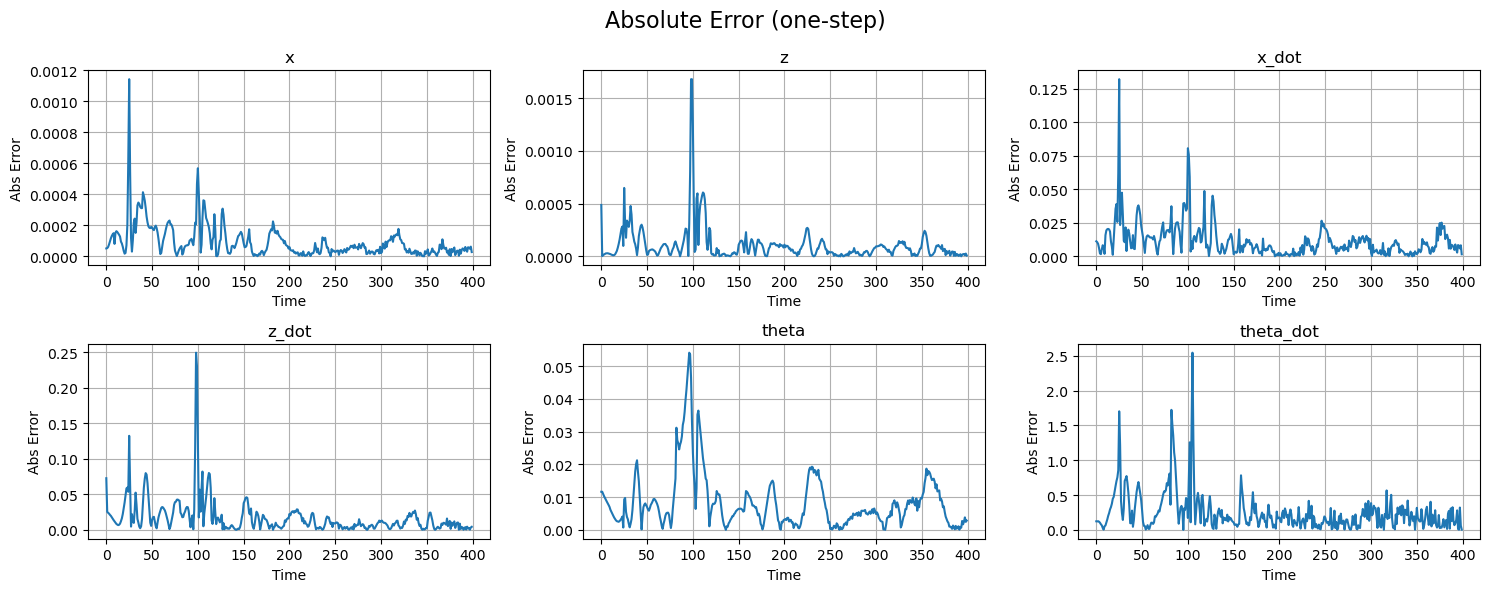

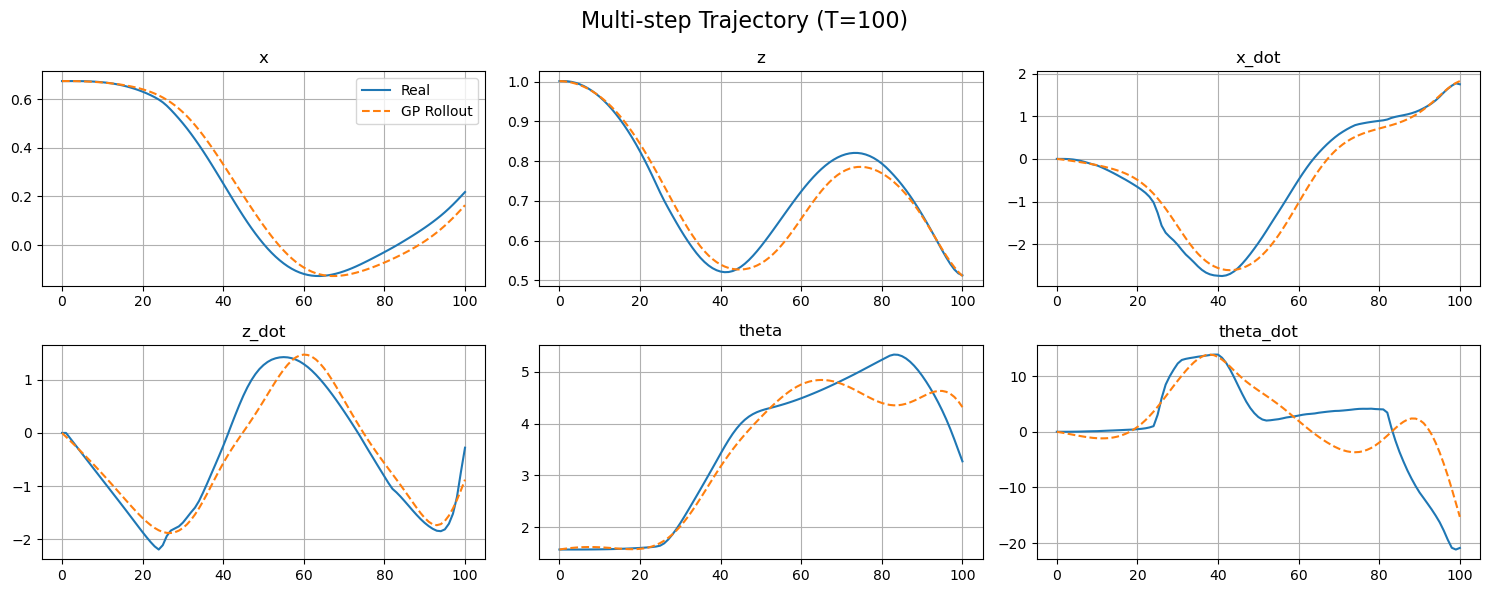

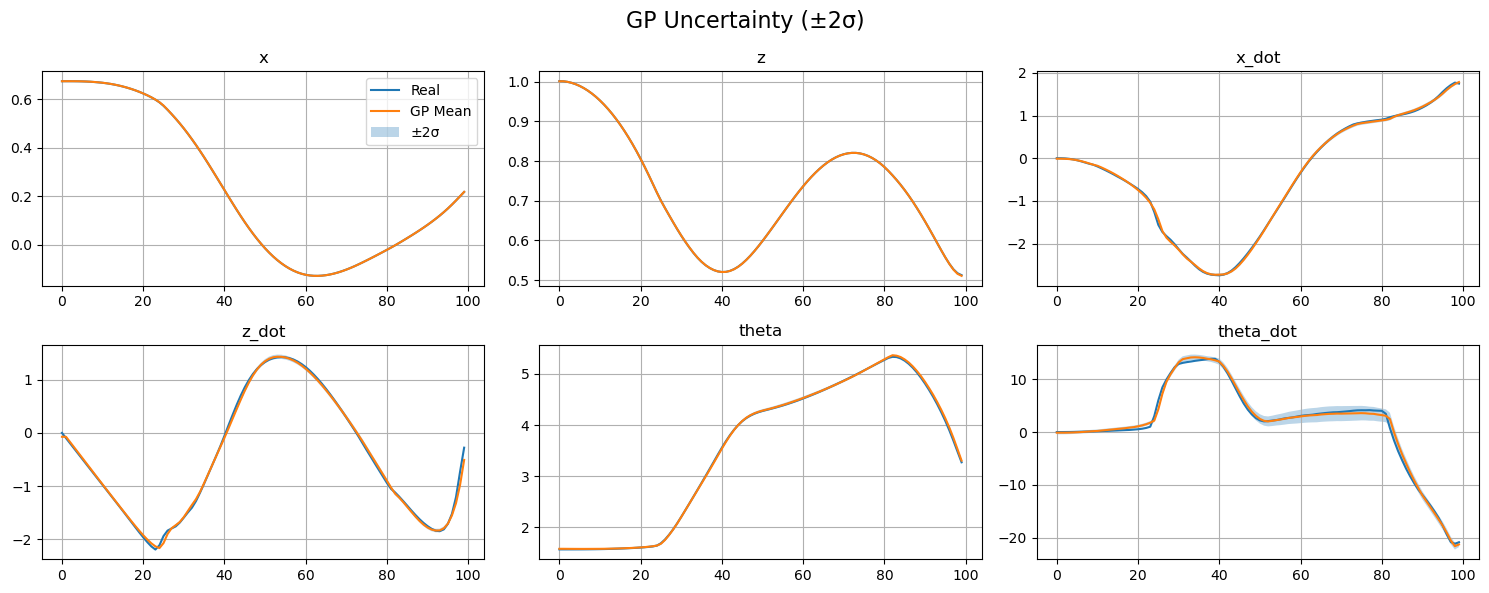


📊 MÉTRICAS DE REGRESIÓN POR DIMENSIÓN
         x | RMSE=0.000155 | MAE=0.000107 | R²=1.0000
         z | RMSE=0.000168 | MAE=0.000102 | R²=1.0000
     x_dot | RMSE=0.029320 | MAE=0.019764 | R²=0.9980
     z_dot | RMSE=0.029666 | MAE=0.018398 | R²=0.9970
     theta | RMSE=0.017748 | MAE=0.009882 | R²=1.0000
 theta_dot | RMSE=1.129882 | MAE=0.796806 | R²=0.9696


In [18]:
# ===============================================
# 8. PREDICCIONES GP PRECOMPUTADAS (UNA SOLA VEZ)
# ===============================================
import numpy as np
import matplotlib.pyplot as plt

DIM_LABELS = ["x", "z", "x_dot", "z_dot", "theta", "theta_dot"]

N, state_dim = states.shape

# Construir X_all = [state, action] para TODO el dataset
X_all = np.concatenate([states, actions], axis=1).astype(np.float32)   # [N, 8]

# mean_delta_all[d]: Δs_pred_dim_d, var_delta_all[d]: var(Δs_dim_d)
mean_delta_all = np.zeros((N, state_dim), dtype=np.float32)
var_delta_all  = np.zeros((N, state_dim), dtype=np.float32)

print("⚙️ Calculando predicciones GP (una sola vez)...")
for d, gp in enumerate(gps):
    m, v = gp.predict(X_all)          # m, v: [N]
    mean_delta_all[:, d] = m
    var_delta_all[:, d]  = v

# Predicción one-step del siguiente estado:
s_pred_all   = states + mean_delta_all           # [N, 6]  → s_{t+1}^{pred}
std_next_all = np.sqrt(var_delta_all)            # desv. estándar de s_{t+1}
print("✅ Predicciones GP precomputadas.")

# Parámetros de horizonte
ONE_STEP_T = 400      # pasos para one-step
ERROR_T    = 400      # pasos para error absoluto
TRAJ_T     = 100      # pasos multi-step rollout
UNC_T      = 100      # pasos para incertidumbre


# ===============================================
# 9. GRÁFICAS COMPACTAS (2x3) USANDO ARRAYS PRECOMPUTADOS
# ===============================================

# -----------------------------
# 9.1 One-step: Real vs GP
# -----------------------------
def plot_one_step_grid(next_states, s_pred_all, T=ONE_STEP_T):
    T = min(T, len(next_states)-1)
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for d in range(6):
        ax = axes[d]
        ax.plot(next_states[:T, d], label="Real")
        ax.plot(s_pred_all[:T, d], '--', label="GP Pred")
        ax.set_title(DIM_LABELS[d])
        ax.grid(True)
        if d == 0:
            ax.legend()

    fig.suptitle("One-step prediction: Real vs GP", fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 9.2 Error absoluto
# -----------------------------
def plot_abs_error_grid(next_states, s_pred_all, T=ERROR_T):
    T = min(T, len(next_states)-1)
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    abs_err = np.abs(next_states - s_pred_all)   # [N, 6]

    for d in range(6):
        ax = axes[d]
        ax.plot(abs_err[:T, d])
        ax.set_title(DIM_LABELS[d])
        ax.set_xlabel("Time")
        ax.set_ylabel("Abs Error")
        ax.grid(True)

    fig.suptitle("Absolute Error (one-step)", fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 9.3 Multi-step rollout
# -----------------------------
def rollout_gp(initial_state, actions, gps, T=TRAJ_T):
    T = min(T, len(actions)-1)
    s = initial_state.copy()
    traj = [s.copy()]
    for t in range(T):
        a = actions[t]
        s, _ = gp_dynamics_step(gps, s, a)
        traj.append(s.copy())
    return np.array(traj)   # [T+1, 6]


def plot_trajectory_grid(states, actions, gps, T=TRAJ_T):
    T = min(T, len(actions)-1)
    traj_gp = rollout_gp(states[0], actions, gps, T)  # [T+1, 6]

    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for d in range(6):
        ax = axes[d]
        ax.plot(states[:T+1, d], label="Real")
        ax.plot(traj_gp[:T+1, d], '--', label="GP Rollout")
        ax.set_title(DIM_LABELS[d])
        ax.grid(True)
        if d == 0:
            ax.legend()

    fig.suptitle(f"Multi-step Trajectory (T={T})", fontsize=16)
    plt.tight_layout()
    plt.show()


# -----------------------------
# 9.4 Incertidumbre (±2σ)
# -----------------------------
def plot_uncertainty_grid(next_states, s_pred_all, std_next_all, T=UNC_T):
    T = min(T, len(next_states)-1)
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for d in range(6):
        ax = axes[d]
        mean = s_pred_all[:T, d]
        std  = std_next_all[:T, d]

        ax.plot(next_states[:T, d], label="Real")
        ax.plot(mean, label="GP Mean")
        ax.fill_between(
            range(T),
            mean - 2*std,
            mean + 2*std,
            alpha=0.3,
            label="±2σ"
        )
        ax.set_title(DIM_LABELS[d])
        ax.grid(True)
        if d == 0:
            ax.legend()

    fig.suptitle("GP Uncertainty (±2σ)", fontsize=16)
    plt.tight_layout()
    plt.show()


# ===============================================
# 10. MÉTRICAS GLOBALES (RMSE, MAE, R²)
# ===============================================
def regression_metrics(next_states, s_pred_all):
    y_true = next_states
    y_pred = s_pred_all

    print("\n📊 MÉTRICAS DE REGRESIÓN POR DIMENSIÓN")
    print("===============================================")
    for d in range(y_true.shape[1]):
        diff = y_true[:, d] - y_pred[:, d]
        mse  = np.mean(diff**2)
        rmse = np.sqrt(mse)
        mae  = np.mean(np.abs(diff))

        var_y = np.var(y_true[:, d])
        if var_y < 1e-12:
            r2 = float('nan')
        else:
            r2 = 1.0 - mse / var_y

        print(f"{DIM_LABELS[d]:>10s} | RMSE={rmse:.6f} | MAE={mae:.6f} | R²={r2:.4f}")


# ===============================================
# 11. LLAMADA A TODAS LAS EVALUACIONES
# ===============================================

print("\n🚀 Generando figuras de comparación compactas (2x3 por tipo)...")

plot_one_step_grid(next_states, s_pred_all)
plot_abs_error_grid(next_states, s_pred_all)
plot_trajectory_grid(states, actions, gps)
plot_uncertainty_grid(next_states, s_pred_all, std_next_all)
regression_metrics(next_states, s_pred_all)


## MPPI Controller

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# =====================================================
# 0️⃣ Device y parámetros generales MPPI
# =====================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("MPPI usando device:", device)

state_dim = 6   # [x, z, x_dot, z_dot, theta, theta_dot]
action_dim = 2  # [u_left, u_right]

# Horizonte y muestras MPPI
H = 5          # horizonte en pasos
K = 1024*2**6         # número de trayectorias MPPI
lambda_mppi = 1.0  # "temperatura" MPPI
ctrl_min = 0.0
ctrl_max = 2.0

# Pesos de costo (puedes tunearlos)
weights = {
    "x_pos":      60.0,
    "z_pos":      80.0,
    "x_vel":      20.0,
    "z_vel":      20.0,
    "theta":      100.0,
    "theta_dot":  30.0,
    "ctrl_effort": 0.01,
    "ctrl_asym":   0.05,
}

# Objetivo (ejemplo): hover en (x=0.5, z=1.2, θ=0)
goal = np.array([0.67, 1.0, 0.0, 0.0, 1.57, 0.0], dtype=np.float32)
goal_t = torch.tensor(goal, device=device)


# =====================================================
# 1️⃣ Dinámica GP en batch (GPU)
# =====================================================
@torch.no_grad()
def gp_dynamics_step_batch(gps, states, actions):
    """
    states:  [K, state_dim]   (torch, device)
    actions: [K, action_dim]  (torch, device)
    Devuelve next_states: [K, state_dim]
    Usa directamente los modelos GPyTorch desde GPManager.
    """
    K = states.shape[0]
    x = torch.cat([states, actions], dim=-1)  # [K, 8]

    next_states = []

    for d, gp in enumerate(gps):
        # Normalizar inputs con las stats de ESTE GP
        X_mean = gp.X_mean
        X_std  = gp.X_std
        Xn = (x - X_mean) / (X_std + 1e-8)

        with gpytorch.settings.fast_pred_var():
            pred = gp.likelihood(gp.model(Xn))
            mean_n = pred.mean             # [K]
            # var_n = pred.variance        # si quieres varianza, puedes usarla

        # Desnormalizar la salida
        Y_mean = gp.Y_mean
        Y_std  = gp.Y_std
        delta_d = mean_n * Y_std + Y_mean   # [K]
        next_states.append(delta_d.unsqueeze(-1))

    delta = torch.cat(next_states, dim=-1)    # [K, 6]
    next_states = states + delta
    return next_states


# =====================================================
# 2️⃣ Función de costo en batch
# =====================================================
def mppi_cost(states, actions, goal_t, weights):
    """
    states:  [K, H, 6]
    actions: [K, H, 2]
    goal_t:  [6] (torch)
    Devuelve cost: [K]
    """
    # Diferencia con el objetivo
    err = states - goal_t  # broadcasting: [K, H, 6]

    x      = err[..., 0]
    z      = err[..., 1]
    x_vel  = err[..., 2]
    z_vel  = err[..., 3]
    theta  = err[..., 4]
    theta_dot = err[..., 5]

    u_left  = actions[..., 0]
    u_right = actions[..., 1]

    # Costos de estado
    cost_state = (
        weights["x_pos"]   * x**2 +
        weights["z_pos"]   * z**2 +
        weights["x_vel"]   * x_vel**2 +
        weights["z_vel"]   * z_vel**2 +
        weights["theta"]   * theta**2 +
        weights["theta_dot"] * theta_dot**2
    )

    # Costo de control
    ctrl_effort = u_left**2 + u_right**2
    ctrl_asym   = (u_left - u_right)**2

    cost_ctrl = (
        weights["ctrl_effort"] * ctrl_effort +
        weights["ctrl_asym"]   * ctrl_asym
    )

    total_cost_per_step = cost_state + cost_ctrl   # [K, H]
    # Sumar en el horizonte
    return total_cost_per_step.sum(dim=-1)         # [K]


# =====================================================
# 3️⃣ Paso de MPPI (una iteración)
# =====================================================
@torch.no_grad()
def mppi_step(gps, current_state_np, u_nominal, goal_t, weights,
              H=30, K=512, lambda_mppi=1.0,
              ctrl_min=0.0, ctrl_max=2.0, noise_sigma=0.3):

    """
    current_state_np: [6] numpy
    u_nominal: [H, 2] tensor en device (secuencias base)
    Devuelve:
      - u_nominal_new: [H, 2]
      - u_apply: [2] control a aplicar
    """

    current_state = torch.tensor(current_state_np, dtype=torch.float32, device=device)
    current_state = current_state.unsqueeze(0)  # [1, 6]

    # Expandir estado inicial para las K trayectorias
    s = current_state.repeat(K, 1)  # [K, 6]

    # Muestreamos ruido para todo el horizonte y trayectorias
    noise = torch.randn(K, H, action_dim, device=device) * noise_sigma   # [K, H, 2]

    # Construir secuencias de control perturbadas
    u_seq = u_nominal.unsqueeze(0) + noise   # [1,H,2] + [K,H,2] → [K,H,2]
    u_seq = torch.clamp(u_seq, ctrl_min, ctrl_max)

    # Rollout
    states_rollout = torch.zeros(K, H, state_dim, device=device)
    actions_rollout = u_seq.clone()

    s_t = s
    for t in range(H):
        u_t = u_seq[:, t, :]
        s_t = gp_dynamics_step_batch(gps, s_t, u_t)
        states_rollout[:, t, :] = s_t

    # Costo total por trayectoria
    costs = mppi_cost(states_rollout, actions_rollout, goal_t, weights)  # [K]

    # MPPI weights
    costs_min = costs.min()
    exp_term = torch.exp(-(costs - costs_min) / lambda_mppi)
    w = exp_term / (exp_term.sum() + 1e-8)   # [K]

    # Actualización de la secuencia nominal
    # u_nominal_new = u_nominal + sum_k w_k * noise_k
    weighted_noise = (w.view(K, 1, 1) * noise).sum(dim=0)   # [H, 2]
    u_nominal_new = u_nominal + weighted_noise
    u_nominal_new = torch.clamp(u_nominal_new, ctrl_min, ctrl_max)

    # Control a aplicar: primer paso de la secuencia nominal nueva
    u_apply = u_nominal_new[0].detach()

    return u_nominal_new, u_apply



MPPI usando device: cuda


In [37]:
# =====================================================
# 4️⃣ Simulación en lazo cerrado (MPPI + MuJoCo) + SVGP online
# =====================================================

BLOCK_STEPS = 1  # número de acciones que aplicas antes de volver a llamar a MPPI

for loop_run in range(1):  # puedes hacer varias corridas completas
    print(f"\n=== Simulación MPPI + GP Online: Run {loop_run+1} ===")

    T_sim = 300  # pasos de simulación totales

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("MPPI usando device:", device)

    u_nominal = torch.zeros(H, action_dim, device=device)  # secuencia inicial

    # Logs
    traj_s = []
    traj_u = []
    traj_cost = []
    frames = []

    prev_theta = None

    # Reset MuJoCo
    mj.mj_resetData(model, data)
    mj.mj_forward(model, data)

    # 🔹 Renderer para capturar frames (offscreen)
    render_height = 480
    render_width  = 640
    renderer = mj.Renderer(model, height=render_height, width=render_width)

    # Buffers para datos online del GP
    online_states = []
    online_actions = []
    online_next_states = []

    # Progreso
    from tqdm import tqdm
    t = 0
    pbar = tqdm(total=T_sim)

    while t < T_sim:

    #     # Objetivo variable
    #     z_pos_goal = 0.2*np.sin(1/30*t)+0.8
    #     z_vel_goal = 0.2*np.cos(1/30*t)*(1/30)
    #     x_pos_goal = 0.1*np.sin(1/30*t)+0.5
    #     x_vel_goal = 0.1*np.cos(1/30*t)*(1/30)
    #     goal = np.array([x_pos_goal, z_pos_goal, x_vel_goal, z_vel_goal, 1.57, 0.0], dtype=np.float32)
    #     goal_t = torch.tensor(goal, device=device)

    #     # Pesos de costo (puedes tunearlos)
    #     weights = {
    #     "x_pos":      60,
    #     "z_pos":      80.0,
    #     "x_vel":      20.0,
    #     "z_vel":      20.0,
    #     "theta":      100.0,
    #     "theta_dot":  30.0,
    #     "ctrl_effort": 0.01,
    #     "ctrl_asym":   0.05,
    # }

        # Leer estado actual al comienzo del bloque
        current_state, prev_theta = get_state_from_sensors(data, prev_theta)

        # MPPI: una optimización sobre H pasos, usando u_nominal como warm start
        u_nominal, _ = mppi_step(
            gps, current_state, u_nominal, goal_t, weights,
            H=H, K=K, lambda_mppi=lambda_mppi,
            ctrl_min=ctrl_min, ctrl_max=ctrl_max,
            noise_sigma=0.3
        )

        # Trabajamos con una copia para este bloque
        u_seq = u_nominal.clone()  # [H, 2]

        # ¿Cuántos pasos de este bloque vamos a ejecutar?
        steps_this_block = min(BLOCK_STEPS, T_sim - t)

        for k in range(steps_this_block):
            # Estado antes de aplicar la acción k del bloque
            s_t = current_state.copy()
            traj_s.append(s_t)

            # Acción a aplicar: la k-ésima de la secuencia óptima
            u_k = u_seq[k]              # tensor [2]
            u_np = u_k.detach().cpu().numpy()
            traj_u.append(u_np)

            # Aplicar control a MuJoCo
            data.ctrl[:] = u_np

            # Avanzar simulación un paso
            mj.mj_step(model, data)

            # 🔹 Capturar frame del entorno
            renderer.update_scene(data)
            frame = renderer.render()    # numpy array [H, W, 3], uint8
            frames.append(frame)

            # Leer siguiente estado después de aplicar la acción
            s_next, prev_theta = get_state_from_sensors(data, prev_theta)

            # >>> Guardar muestra para el GP (s_t, u_t, s_{t+1})
            online_states.append(s_t.copy())
            online_actions.append(u_np.copy())
            online_next_states.append(s_next.copy())

            # (coste instantáneo para logging, usando s_t como antes)
            s_t_torch = torch.as_tensor(s_t, dtype=torch.float32, device=device)
            u_t_torch = torch.as_tensor(u_np, dtype=torch.float32, device=device).view(1, 1, -1)

            err = s_t_torch - goal_t
            c_inst = (
                weights["x_pos"]     * err[0]**2 +
                weights["z_pos"]     * err[1]**2 +
                weights["x_vel"]     * err[2]**2 +
                weights["z_vel"]     * err[3]**2 +
                weights["theta"]     * err[4]**2 +
                weights["theta_dot"] * err[5]**2 +
                weights["ctrl_effort"] * (u_t_torch[0,0,0]**2 + u_t_torch[0,0,1]**2) +
                weights["ctrl_asym"]   * (u_t_torch[0,0,0] - u_t_torch[0,0,1])**2
            )
            traj_cost.append(float(c_inst.detach().cpu().item()))

            # Avanzar contador de tiempo global
            t += 1
            pbar.update(1)

            # >>> Cada 10 pasos: añadir datos al SVGP y hacer unas pocas steps online
            if (t % 10) == 0:
                X_new = np.hstack([
                    np.array(online_states),
                    np.array(online_actions)
                ])  # [N, state_dim + action_dim]

                delta_s_new = np.array(online_next_states) - np.array(online_states)  # [N, state_dim]

                for d, gp in enumerate(gps):
                    Y_new_d = delta_s_new[:, d]    # [N]
                    # Aquí puedes activar tu lógica de entrenamiento online:
                    gp.add_data(X_new, Y_new_d, retrain=False, online_steps=50)
                    gp._train(max_steps=50)

                # Vaciar buffers
                online_states.clear()
                online_actions.clear()
                online_next_states.clear()
            # >>> fin bloque online GP

            # Preparar para el siguiente paso dentro del bloque
            current_state = s_next.copy()

            if t >= T_sim:
                break  # no pasar de T_sim

        # OPCIONAL: "shift" de u_nominal para el siguiente bloque
        # (calentar el MPPI con la parte futura de la secuencia actual)
        shift = min(BLOCK_STEPS, H-1)
        u_nominal = torch.roll(u_nominal, shifts=-shift, dims=0)
        u_nominal[-shift:] = u_nominal[-shift-1].clone()

    pbar.close()

    # Convertir logs a arrays
    traj_s = np.array(traj_s)        # [T_sim, 6]
    traj_u = np.array(traj_u)        # [T_sim, 2]
    traj_cost = np.array(traj_cost)  # [T_sim]

    print("✅ Simulación MPPI + SVGP online completada.")
    print(f"\n📊 Tamaño final del dataset usado por los GPs: {gp.X.shape[0]} puntos de datos.")

    # ===============================================
    # 5️⃣ Guardar modelos GP finales tras la simulación online
    # ===============================================
    # for d, gp in enumerate(gps):
    #     gp_path = os.path.join(MODEL_DIR, f"svgp3_dim{d}.pth")
    #     save_gp(gp, gp_path)



=== Simulación MPPI + GP Online: Run 1 ===
MPPI usando device: cuda


100%|██████████| 300/300 [02:09<00:00,  2.32it/s]

✅ Simulación MPPI + SVGP online completada.

📊 Tamaño final del dataset usado por los GPs: 5500 puntos de datos.


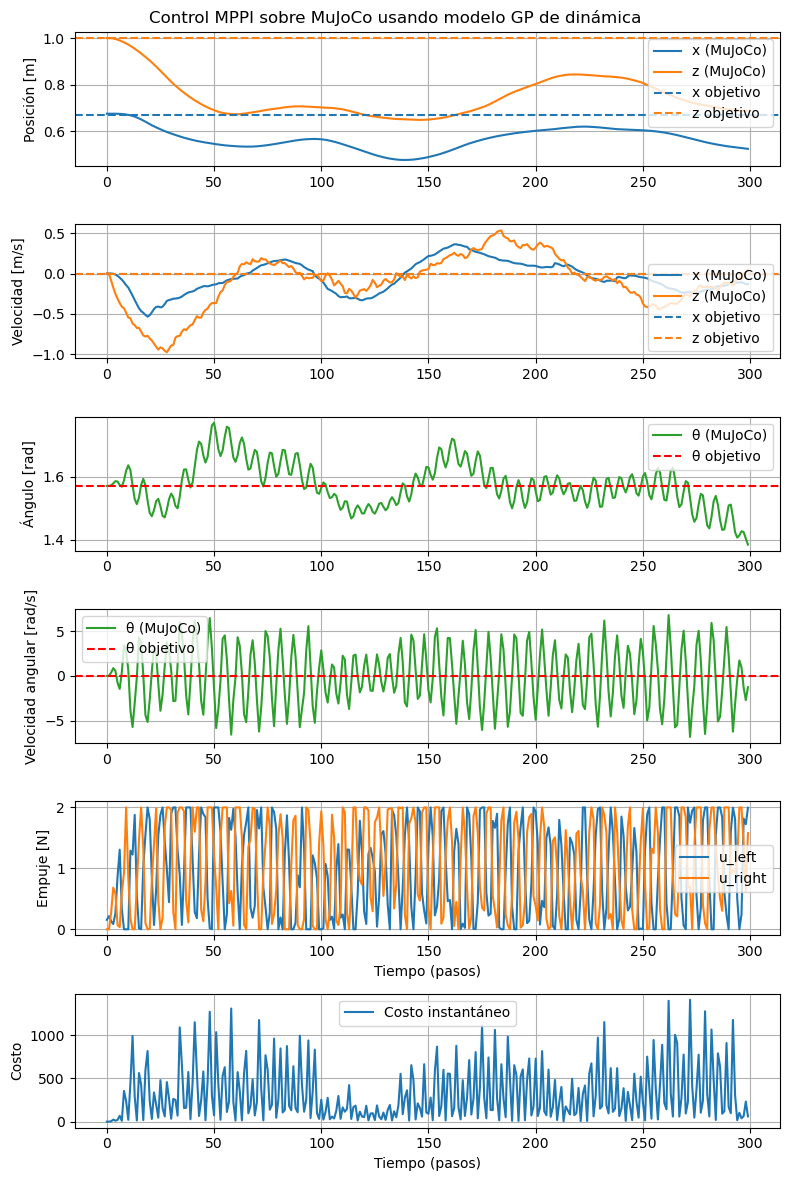

In [38]:
# =====================================================
# 5️⃣ Gráficos de estado / acción / costo
# =====================================================
fig, axes = plt.subplots(6, 1, figsize=(8, 12))

# 1) Posición x, z
axes[0].plot(traj_s[:,0], label="x (MuJoCo)", color='C0')
axes[0].plot(traj_s[:,1], label="z (MuJoCo)", color='C1')
axes[0].axhline(goal[0], color='C0', linestyle='--', label="x objetivo")
axes[0].axhline(goal[1], color='C1', linestyle='--', label="z objetivo")
axes[0].set_ylabel("Posición [m]")
axes[0].legend()
axes[0].grid()

# 1) Velocidad x, z
axes[1].plot(traj_s[:,2], label="x (MuJoCo)", color='C0')
axes[1].plot(traj_s[:,3], label="z (MuJoCo)", color='C1')
axes[1].axhline(goal[2], color='C0', linestyle='--', label="x objetivo")
axes[1].axhline(goal[3], color='C1', linestyle='--', label="z objetivo")
axes[1].set_ylabel("Velocidad [m/s]")
axes[1].legend(loc='lower right')
axes[1].grid()

# 2) Ángulo θ
axes[2].plot(traj_s[:,4], label="θ (MuJoCo)", color='C2')
axes[2].axhline(goal[4], color='r', linestyle='--', label="θ objetivo")
axes[2].set_ylabel("Ángulo [rad]")
axes[2].legend()
axes[2].grid()

# 2) Velocidad angular θ_dot
axes[3].plot(traj_s[:,5], label="θ (MuJoCo)", color='C2')
axes[3].axhline(goal[5], color='r', linestyle='--', label="θ objetivo")
axes[3].set_ylabel("Velocidad angular [rad/s]")
axes[3].legend()
axes[3].grid()

# 3) Acciones (empujes)
axes[4].plot(traj_u[:,0], label="u_left")
axes[4].plot(traj_u[:,1], label="u_right")
axes[4].set_ylabel("Empuje [N]")
axes[4].set_xlabel("Tiempo (pasos)")
axes[4].legend()
axes[4].grid()

# 4) Costo instantáneo
axes[5].plot(traj_cost, label="Costo instantáneo")
axes[5].set_ylabel("Costo")
axes[5].set_xlabel("Tiempo (pasos)")
axes[5].legend()
axes[5].grid()

plt.suptitle("Control MPPI sobre MuJoCo usando modelo GP de dinámica")
plt.tight_layout()
plt.show()


In [39]:
# =====================================================
# 6️⃣ Animación tipo Pendulum-v1 (si tienes frames)
# =====================================================
if len(frames) > 0:
    fig = plt.figure()
    img = plt.imshow(frames[0])

    renderer.close()  # cerrar el renderer de MuJoCo si no se necesita más

    def animate(i):
        img.set_data(frames[i])
        return [img]

    ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=30)
    plt.close()

    display(HTML(ani.to_html5_video()))

else:
    print("⚠️ No se capturaron frames. Añade tu función de render y apéndalos en 'frames'.")


In [40]:
# Obtener el tamaño del dataset final
# total_data_points = 0
# for gp in gps:
#     total_data_points = gp.X.shape[0]
print(f"\n📊 Tamaño final del dataset usado por los GPs: {gp.X.shape[0]} puntos de datos.")


📊 Tamaño final del dataset usado por los GPs: 5500 puntos de datos.


In [19]:
for d, gp in enumerate(gps):
    Y_new_d = delta_s_new[:, d]    # [N]
    # Aquí puedes activar tu lógica de entrenamiento online:
    # gp.add_data(X_new, Y_new_d, retrain=False, online_steps=50)
    # gp._train(max_steps=50)


# ===============================================
# 5️⃣ Guardar modelos GP finales tras la simulación online
# ===============================================
for d, gp in enumerate(gps):
    gp_path = os.path.join(MODEL_DIR, f"svgp3_dim{d}.pth")
    save_gp(gp, gp_path)

💾 GP guardado en data/svgp_torch_models\svgp3_dim0.pth
💾 GP guardado en data/svgp_torch_models\svgp3_dim1.pth
💾 GP guardado en data/svgp_torch_models\svgp3_dim2.pth
💾 GP guardado en data/svgp_torch_models\svgp3_dim3.pth
💾 GP guardado en data/svgp_torch_models\svgp3_dim4.pth
💾 GP guardado en data/svgp_torch_models\svgp3_dim5.pth
